# Efficient Multi-Head Attention Implementations

This code notebook compares different ways to implement causal multi-head attention used in decoder-style LLMs like GPT, Llama, etc.

In [1]:
import torch

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

batch_size = 8
context_len = 1024
embed_dim = 768
embeddings = torch.randn((batch_size, context_len, embed_dim), device=device)

PyTorch version: 2.1.0
Running on cpu


## 1) CausalAttention MHA wrapper class from chapter 3

In [2]:
from ch03 import MultiHeadAttentionWrapper as Ch03_MHA_Wrapper

mha_ch03_wrapper = Ch03_MHA_Wrapper(
    d_in=embed_dim,
    d_out=embed_dim//12,
    block_size=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03_wrapper(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 2) The multi-head attention class from chapter 3

In [3]:
from ch03 import MultiHeadAttention as Ch03_MHA

mha_ch03 = Ch03_MHA(
    d_in=embed_dim,
    d_out=embed_dim,
    block_size=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 3) An alternative multi-head attention with combined weights

- The code for the `MultiHeadAttentionAlt` class below is based on code that was kindly shared by [Rayed Bin Wahed](https://github.com/rasbt/LLMs-from-scratch/discussions/51)
- The main difference between the `MultiHeadAttentionAlt` class and the `MultiHeadAttention` class used in chapter 3 is that `MultiHeadAttentionAlt` uses a single weight matrix, `self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)` instead of separate weight matrices:

  - `self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)`
  - `self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)`
  - `self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)`

- Here, `self.qkv` combines all three weight matrices `self.W_query`, `self.W_key`, and `self.W_value` to carry out the query, key, and value computation in a single step
- Using `q, k, v = qkv.unbind(0)`, we obtain the individual query, key, and value tensors, which are then used similarly to the query, key, and value tensors in the `MultiHeadAttention` class in chapter 3

In [4]:
import torch.nn as nn


class MultiHeadAttentionCombinedQKV(nn.Module):
    def __init__(self, d_in, d_out, num_heads, block_size, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.block_size = block_size
        self.head_dim = d_out // num_heads

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_in, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(block_size, block_size), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_head, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        # (b, num_heads, num_tokens, head_dim) --> (b, num_heads, num_tokens, num_tokens)
        attn_scores = queries @ keys.transpose(-2, -1)
        attn_scores = attn_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**-0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # (b, num_heads, num_tokens, num_tokens) --> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values

        # (b, num_heads, num_tokens, head_dim) --> (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)

        # (b, num_tokens, num_heads, head_dim) --> (b, num_tokens, embed_dim)
        context_vec = context_vec.reshape(batch_size, num_tokens, embed_dim)

        context_vec = self.proj(context_vec)

        return context_vec


mha_combined_qkv = MultiHeadAttentionCombinedQKV(
    d_in=embed_dim,
    d_out=embed_dim,
    block_size=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_combined_qkv(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 4) Multihead attention with PyTorch's scaled dot product attention

- The implementation below uses PyTorch's [`scaled_dot_product_attention`](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) function, which implements a memory-optimized version of self-attention calld [flash attention](https://arxiv.org/abs/2205.14135)

In [5]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in, d_out, num_heads, block_size, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.block_size = block_size
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_in, d_out)
        self.dropout = dropout

        self.register_buffer(
            "mask", torch.triu(torch.ones(block_size, block_size), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        use_dropout = 0. if not self.training else self.dropout
        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        return context_vec

In [6]:
mha_pytorch_scaled = MHAPyTorchScaledDotProduct(
    d_in=embed_dim,
    d_out=embed_dim,
    block_size=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_scaled(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 5) Using PyTorch's torch.nn.MultiheadAttention

- Below, we use PyTorch's [torch.nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) implementation

In [7]:
import torch.nn as nn


class MHAPyTorchClass(nn.Module):
    def __init__(self, d_in, d_out, num_heads, block_size, dropout=0.0, qkv_bias=False, need_weights=True):
        super().__init__()

        self.block_size = block_size
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            batch_first=True,
        )

        self.need_weights = need_weights
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(block_size, block_size), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, _ = x.shape

        # Ensure attn_mask is compatible with expected shape and `batch_first=True`
        # No need to manually adjust for num_heads; ensure it's right for the sequence
        if self.block_size >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.block_size, :self.block_size]

        # attn_mask broadcasting will handle batch_size dimension implicitly
        attn_output, _ = self.multihead_attn(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )

        output = self.proj(attn_output)

        return output


mha_pytorch_class_default = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    block_size=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_class_default(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## 6) Using PyTorch's torch.nn.MultiheadAttention with `scaled_dot_product_attention`

- Set `need_weights` (default `True`) to need_weights=False so that MultiheadAttention uses `scaled_dot_product_attention` [according to the documentation](https://github.com/pytorch/pytorch/blob/71d020262793542974cf13b30f2a9099773f015c/torch/nn/modules/activation.py#L1096)

>  need_weights: If specified, returns ``attn_output_weights`` in addition to ``attn_outputs``.
            Set ``need_weights=False`` to use the optimized ``scaled_dot_product_attention``
            and achieve the best performance for MHA.
            Default: ``True``.

In [8]:
mha_pytorch_class_noweights = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    block_size=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False,
    need_weights=False # NEW!
).to(device)

out = mha_pytorch_class_noweights(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


## Quick speed comparison (M3 Macbook Air CPU)

In [9]:
## 1) CausalAttention MHA wrapper class from chapter 3
%timeit mha_ch03_wrapper(embeddings)

194 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
## 2) The multi-head attention class from chapter 3
%timeit mha_ch03(embeddings)

198 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
## 3) An alternative multi-head attention with combined weights
%timeit mha_combined_qkv(embeddings)

234 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
## 4) Multihead attention with PyTorch's scaled dot product attention
%timeit mha_pytorch_scaled(embeddings)

71.7 ms ± 3.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
## 5) Using PyTorch's torch.nn.MultiheadAttention
%timeit mha_pytorch_class_default(embeddings)

211 ms ± 5.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
## 6) Using PyTorch's torch.nn.MultiheadAttention disabling `need_weights`
%timeit mha_pytorch_class_noweights(embeddings)

207 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Speed comparison (Nvidia A100 GPU) with warmup

In [15]:
# CUDA benchmark code shared by Andrei Aksionov
# and based on code from
# https://github.com/cuda-mode/lectures/blob/main/lecture1/pytorch_square.py

import time

def time_pytorch_function(func, *input, num_repeats = 100):
    # CUDA IS ASYNC so can't use python time module
    #start = torch.cuda.Event(enable_timing=True)
    #end = torch.cuda.Event(enable_timing=True)
    start = time.time()
    # Warmup
    #for _ in range(5):
    #    func(*input)
    #torch.cuda.synchronize()

    #start.record()
    for _ in range(num_repeats):
        func(*input)
        #torch.cuda.synchronize()
    #end.record()
    #torch.cuda.synchronize()
    return (time.time()-start) / num_repeats

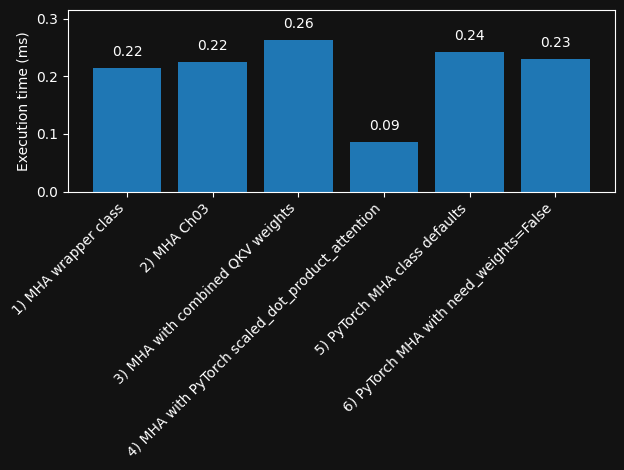

In [16]:

import matplotlib.pyplot as plt


#embeddings_cuda = embeddings.to(torch.device("cuda"))

functions = {
    "1) MHA wrapper class": mha_ch03_wrapper,
    "2) MHA Ch03": mha_ch03,
    "3) MHA with combined QKV weights": mha_combined_qkv,
    "4) MHA with PyTorch scaled_dot_product_attention": mha_pytorch_scaled,
    "5) PyTorch MHA class defaults": mha_pytorch_class_default,
    "6) PyTorch MHA with need_weights=False": mha_pytorch_class_noweights
}
execution_times = [time_pytorch_function(fn, embeddings) for name,fn in functions.items()]


# Plotting

# Customize further for dark mode aesthetics
plt.rcParams['figure.facecolor'] = '#121212'  # Dark figure background
plt.rcParams['axes.facecolor'] = '#121212'    # Dark axes background
plt.rcParams['axes.edgecolor'] = 'white'      # White axes border
plt.rcParams['axes.labelcolor'] = 'white'     # White labels
plt.rcParams['text.color'] = 'white'          # White text
plt.rcParams['xtick.color'] = 'white'         # White x ticks
plt.rcParams['ytick.color'] = 'white'         # White y ticks
plt.rcParams['grid.color'] = '#444444'        # Lighter grid lines for contrast
plt.rcParams['lines.linewidth'] = 2           # Thicker plot lines for visibility
plt.rcParams['lines.markersize'] = 8          # Larger markers for visibility

fig, ax = plt.subplots()
bars = plt.bar(functions.keys(), execution_times)

plt.ylabel('Execution time (ms)')
plt.xticks(rotation=45, ha="right")

# Calculate new ylim with a margin
max_execution_time = max(execution_times)
upper_ylim = max_execution_time + 0.2 * max_execution_time  # Adding a 20% margin

plt.ylim(0, upper_ylim)  # Setting new ylim

# Annotate bars with execution times
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha='center', va='bottom')


plt.tight_layout()
plt.savefig("2.pdf")
plt.show()